In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.0.8'

# Deep Dream

This notebook contains the code samples found in Chapter 8, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

[...]

## Implementing Deep Dream in Keras


We will start from a convnet pre-trained on ImageNet. In Keras, we have many such convnets available: VGG16, VGG19, Xception, ResNet50... 
albeit the same process is doable with any of these, your convnet of choice will naturally affect your visualizations, since different 
convnet architectures result in different learned features. The convnet used in the original Deep Dream release was an Inception model, and 
in practice Inception is known to produce very nice-looking Deep Dreams, so we will use the InceptionV3 model that comes with Keras.


In [2]:
from keras.applications import inception_v3
from keras import backend as K

# We will not be training our model,
# so we use this command to disable all training-specific operations
K.set_learning_phase(0)

# Build the InceptionV3 network.
# The model will be loaded with pre-trained ImageNet weights.
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)

87900160/87910968 [============================>.] - ETA: 0s


Next, we compute the "loss", the quantity that we will seek to maximize during the gradient ascent process. In Chapter 5, for filter 
visualization, we were trying to maximize the value of a specific filter in a specific layer. Here we will simultaneously maximize the 
activation of all filters in a number of layers. Specifically, we will maximize a weighted sum of the L2 norm of the activations of a 
set of high-level layers. The exact set of layers we pick (as well as their contribution to the final loss) has a large influence on the 
visuals that we will be able to produce, so we want to make these parameters easily configurable. Lower layers result in 
geometric patterns, while higher layers result in visuals in which you can recognize some classes from ImageNet (e.g. birds or dogs).
We'll start from a somewhat arbitrary configuration involving four layers -- 
but you will definitely want to explore many different configurations later on:

In [3]:
# Dict mapping layer names to a coefficient
# quantifying how much the layer's activation
# will contribute to the loss we will seek to maximize.
# Note that these are layer names as they appear
# in the built-in InceptionV3 application.
# You can list all layer names using `model.summary()`.
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

Now let's define a tensor that contains our loss, i.e. the weighted sum of the L2 norm of the activations of the layers listed above.

In [4]:
# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Define the loss.
loss = K.variable(0.)
for layer_name in layer_contributions:
    # Add the L2 norm of the features of a layer to the loss.
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output

    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

Now we can set up the gradient ascent process:

In [5]:
# This holds our generated image
dream = model.input

# Compute the gradients of the dream with regard to the loss.
grads = K.gradients(loss, dream)[0]

# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x


Finally, here is the actual Deep Dream algorithm.

First, we define a list of "scales" (also called "octaves") at which we will process the images. Each successive scale is larger than 
previous one by a factor 1.4 (i.e. 40% larger): we start by processing a small image and we increasingly upscale it:

![deep dream process](https://s3.amazonaws.com/book.keras.io/img/ch8/deepdream_process.png)


Then, for each successive scale, from the smallest to the largest, we run gradient ascent to maximize the loss we have previously defined, 
at that scale. After each gradient ascent run, we upscale the resulting image by 40%.

To avoid losing a lot of image detail after each successive upscaling (resulting in increasingly blurry or pixelated images), we leverage a 
simple trick: after each upscaling, we reinject the lost details back into the image, which is possible since we know what the original 
image should look like at the larger scale. Given a small image S and a larger image size L, we can compute the difference between the 
original image (assumed larger than L) resized to size L and the original resized to size S -- this difference quantifies the details lost 
when going from S to L.

The code above below leverages the following straightforward auxiliary Numpy functions, which all do just as their name suggests. They 
require to have SciPy installed.

In [6]:
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [7]:
import numpy as np

# Playing with these hyperparameters will also allow you to achieve new effects

step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale

# If our loss gets larger than 10,
# we will interrupt the gradient ascent process, to avoid ugly artifacts
max_loss = 10.

# Fill this to the path to the image you want to use
base_image_path = '/output/original_photo_deep_dream.jpg'

# Load the image into a Numpy array
img = preprocess_image(base_image_path)

# We prepare a list of shape tuples
# defining the different scales at which we will run gradient ascent
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# Reverse list of shapes, so that they are in increasing order
successive_shapes = successive_shapes[::-1]

# Resize the Numpy array of the image to our smallest scale
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='/output/dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='/output/final_dream.png')

Processing image shape (93, 93)
...Loss value at 0 : 0.0291683
...Loss value at 1 : 0.0401157
...Loss value at 2 : 0.0513632
...Loss value at 3 : 0.0594412
...Loss value at 4 : 0.0681041
...Loss value at 5 : 0.0773775
...Loss value at 6 : 0.0856496
...Loss value at 7 : 0.0947909
...Loss value at 8 : 0.103228
...Loss value at 9 : 0.108836
...Loss value at 10 : 0.114438
...Loss value at 11 : 0.121777
...Loss value at 12 : 0.127995
...Loss value at 13 : 0.130211
...Loss value at 14 : 0.138349
...Loss value at 15 : 0.143556
...Loss value at 16 : 0.149331
...Loss value at 17 : 0.153561
...Loss value at 18 : 0.161289
...Loss value at 19 : 0.165294
Processing image shape (130, 131)
...Loss value at 0 : 0.565682
...Loss value at 1 : 0.878274
...Loss value at 2 : 1.11536
...Loss value at 3 : 1.31696
...Loss value at 4 : 1.54208
...Loss value at 5 : 1.71149
...Loss value at 6 : 1.96211
...Loss value at 7 : 2.121
...Loss value at 8 : 2.36041
...Loss value at 9 : 2.64717
...Loss value at 10 : 2.71

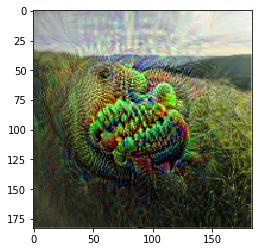

In [8]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()